# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
#from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [79]:
def get_A(alpha):
    len_alpha = len(alpha)
    A = np.zeros((len_alpha, len_alpha))
    for i in range(len_alpha):
        A[i, i] = alpha[i]
    return A

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    
    A = get_A(alpha)
    
    inv_sigma = beta * XtransposeX + A
    
    alpha_mask = alpha != np.inf
    
    sigma = np.zeros((d, d))
    
    dop = np.arange(d)[alpha_mask]
    s = np.linalg.inv(inv_sigma[dop][:, dop])
    i1 = 0
    for i in dop:
        j1 = 0
        for j in dop:
            sigma[i, j] = s[i1, j1]
            j1 += 1
        i1 += 1
    
    w = beta * np.dot(sigma, XtransposeT)
       
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""
    AlphaBound = 1e8
    WeightBound = 1e-20

    w, sigma = get_w_sigma(X, t, alpha, beta)
    n, d = X.shape

    diag_sigma = np.diag(sigma)
    
    mask1 = alpha <= AlphaBound
    mask2 = np.abs(w) >= WeightBound
    
    
    mask = mask1 * mask2
    
    wmp = np.zeros(d)
    wmp[mask] = w[mask]
    
    alpha_new = np.array([np.inf] * d)
    
    gamma = 1 - alpha[mask] * diag_sigma[mask]
    
    alpha_new = np.array([np.inf] * d)
    alpha_new[mask] = gamma / (wmp[mask])**2
        
    beta_new = (n - np.sum(gamma)) / np.sum((t - np.dot(X, wmp))**2)
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    n, d = X.shape
    
    alpha = np.ones(d)
    beta = 1
       
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
    
    w, sigma = get_w_sigma(X, t, alpha, beta)
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

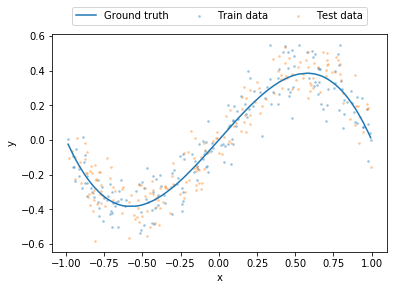

In [63]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [64]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [65]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [66]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

In [67]:
alpha_rvr

array([       inf, 1.00114377,        inf, 1.02012711,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf])

In [69]:
w_rvr

array([ 0.        ,  0.99893806,  0.        , -0.98891511,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

Relevance Vector Regression
Features remaining: 2 / 21
Train error: 0.009793511724040617
Test error:  0.00880250323265006
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009817261869833303
Test error:  0.009217160757449215
--------------------------------------------------
Lasso Regression
Features remaining: 6 / 21
Train error: 0.009761446036178597
Test error:  0.008984453009022859


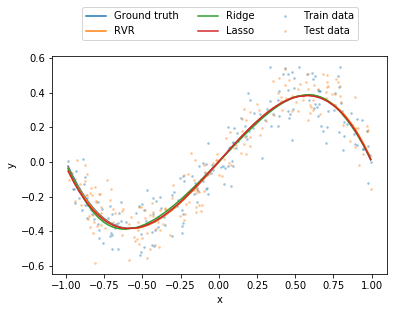

In [68]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Таким образом, в случае с RVR ошибка на тестовой выборке меньше, чем при использовании Lasso и гребневой регрессии. А ошибка при использовании Lasso меньше, чем в случае с Ridge Regression. При этом RVR оставляет 2 признака из 21. Это абсолютно логично, достаточно посмотреть на то, как генерируются данные. В данном эксперименте RVR показало лучшие результаты как по качеству предсказания, так и по качеству отобранных признаков(в сравнении с Lasso, которая оставила 6 признаков и Ridge, которая не производит отбор признаков).

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

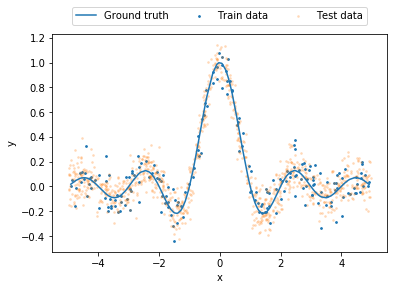

In [107]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape((-1, 1)), points_train.reshape((-1, 1)))
X_test = rbf_kernel(points_test.reshape((-1, 1)), points_train.reshape((-1, 1)))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()
XtransposeX = np.dot(X_train.T, X_train)
XtransposeT = np.dot(X_train.T, t_train)

In [108]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [109]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [110]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

In [118]:
np.arange(len(w_rvr))[w_rvr != 0]

array([ 16,  35,  52,  74,  93, 117, 138, 139, 165, 200])

Relevance Vector Regression
Objects remaining: 10 / 200
Train error: 0.010265233353372141
Test error:  0.049887704722148776
--------------------------------------------------
Lasso Regression
Objects remaining: 87 / 200
Train error: 0.010422117272541888
Test error:  0.05103627024203931
--------------------------------------------------
Support Vector Regression
Objects remaining: 67 / 200
Train error: 0.010399290861359543
Test error:  0.05199107512732632


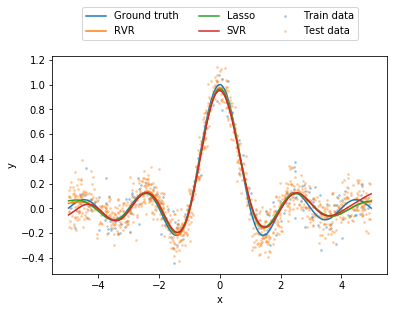

In [113]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

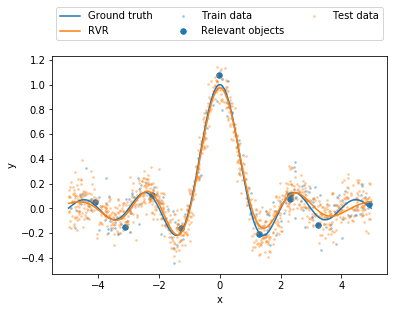

In [114]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Таким образом, в случае с RVR ошибка на тестовой выборке меньше, чем при использовании SVR и Lasso(в случае с Lasso ошибка меньше, чем в случае с SVR). Также при использовании RVR число оставленных релевантных объектов(10) гораздо меньше, чем при использовании SVR(67) и Lasso(87). Релевантные объекты(в случае с RVR) примерно соответствуют точкам локального максимума(за исключением крайней правой точки) функции sinc(x). Можно говорить о том, что релевантные объекты отобраны качественно. В данном эксперименте RVR показало лучшие результаты как по качеству предсказания, так и по качеству отобранных объектов.

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

В процессе обучения RVR большинство alpha_i стремятся к бесконечности. Это означает, что соответсвующий вес w_i становится равным 0. Это равносильно ситуации исключения соответствующего признака / объекта из модели. В итоге лишь малое число исходных признаков / объектов входят в решающее правило с отличным от нуля весом. RVR показала лучшие результаты как по качеству предсказания, так и по качеству отбора признаков / объектов в сравнении с другими рассматриваемыми моделями.